In [113]:
import pickle
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

%matplotlib inline


## Exploratory Data Analysis and Building a model for relationship between greenhouse gas emissions from a car and that car's features

Data collection and initial cleaning is complete.  Now for EOA, feature examination, and building an optimal linear regression model.

### Step 1: Prepare dataframe for developing linear regression model
*Edit and add features based on general knowlege of subject and also knowing what features will likely be multicollineary*

-

Open the `all_cars_eda` pickled dataframe with all cars data

In [3]:
with open('data/pickles/all_cars_eda.pickle','rb') as read_file:
    all_cars_eda = pickle.load(read_file)

-

Years feature will be treated categorically because of it's special relationship with greenhouse gas emissions.  The binned categories for `years` is based on the year timeframes that the EPA developed national regulations for cars' greenhouse gas emissions:
- 1984 - 2011: 'pre' strict regulations around emissions
- 2012 - 2021: implementation of regulations around emissions.  Note that regulations were 'loosened' by EPA starting with 2021 models, which will be interesting to analyze in coming years, but as of now (July 2020) there are only 36 cars of the 'year' 2021 so data in that category would not yield reliable insights or value.  For now, will remain in regulations bucket since 2021 cars are still under more regulations than prior to 2012

If we find there's little or no difference between the year periods created, will try other options for categorization or leaving as numeric. >>

In [4]:
all_cars_eda['year_range'] = ['year_pre_regulations' if
                              year in [1984, 1985, 1986, 
                                       1987, 1988, 1989, 
                                       1990, 1991, 1992, 
                                       1993, 1994, 1995, 
                                       1996, 1997, 1998, 
                                       1999, 2000, 2001,
                                       2002, 2003, 2004,
                                       2005, 2006, 2007,
                                       2008, 2009, 2010,
                                       2011]
                              
                              else 'year_regulations' if 
                              year in [2012,2013,2014,2015,
                                       2016,2017,2018,2019,
                                       2020,2021]           
                              
                              else np.nan for year in all_cars_eda['year']]

Verify that here is a strong sample amount in each bucket >>

In [5]:
all_cars_eda.year_range.value_counts()

year_pre_regulations    3553
year_regulations        1707
Name: year_range, dtype: int64

-

**REMOVING FEATURES**

**Removing miles-per-gallon - `mpg`.**  By removing we'll allow opportunity to examine any relationships between the other features of the car and the greenhouse gas emissions, otherwise miles-per-gallon would be too dominant of feature (and have multicollinearity) and also isn't really telling us more deeply what causes greenhouse gas emissions from the mechanics of how the car was built. 

**Removing `make`, `model`, & `trans_speed`.**  Can say with confidence these are not signiciantly relevant to the greenhouse gas emissions of the car and would not be worth create dummies for the non-numberic categories.

**Removing `year`.**  Will now use newly formed `year_range` column for later creating dummies.

In [6]:
del all_cars_eda['mpg']
del all_cars_eda['make']
del all_cars_eda['model']
del all_cars_eda['trans_speed']
del all_cars_eda['year']

Verify digit types look okay and as expected.  Will need to create dummies for transmission, fuel type, adn year range.>>

In [7]:
all_cars_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5260 entries, 0 to 5264
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   capacity_liters  5260 non-null   float64
 1   cylinders        5260 non-null   int32  
 2   transmission     5260 non-null   object 
 3   fuel_type        5260 non-null   object 
 4   gg_emissions     5260 non-null   float64
 5   year_range       5260 non-null   object 
dtypes: float64(2), int32(1), object(3)
memory usage: 267.1+ KB


-

Create the dummies for the features that are objects and then rename columns with proper formatting to work later in graphing code >>

In [8]:
all_cars_eda = pd.get_dummies(all_cars_eda)

In [9]:
all_cars_eda.columns

Index(['capacity_liters', 'cylinders', 'gg_emissions',
       'transmission_Automatic', 'transmission_Manual', 'fuel_type_Diesel',
       'fuel_type_Premium Gasoline', 'fuel_type_Regular Gasoline',
       'year_range_year_pre_regulations', 'year_range_year_regulations'],
      dtype='object')

In [10]:
all_cars_eda.rename(columns = {'fuel_type_Premium Gasoline': 'fuel_premium',
                               'fuel_type_Regular Gasoline': 'fuel_regular',
                               'fuel_type_Diesel': 'fuel_diesel',
                               'year_range_year_pre_regulations': 'year_pre_regulations',
                               'year_range_year_regulations': 'year_regulations'
                              },
                    inplace = True)

-

### Step 2: Exploratory Data Analysis

#### CORRELATION

Examine the correlations of all the values>>

In [11]:
all_cars_eda.corr()

,capacity_liters,cylinders,gg_emissions,transmission_Automatic,transmission_Manual,fuel_diesel,fuel_premium,fuel_regular,year_pre_regulations,year_regulations
capacity_liters,1.000000,0.906330,0.773934,0.264746,-0.264746,0.126013,0.135443,-0.199060,0.149540,-0.149540
cylinders,0.906330,1.000000,0.740521,0.309784,-0.309784,0.064916,0.253522,-0.276253,0.105251,-0.105251
gg_emissions,0.773934,0.740521,1.000000,0.169507,-0.169507,-0.010432,0.117899,-0.105576,0.343847,-0.343847
transmission_Automatic,0.264746,0.309784,0.169507,1.000000,-1.000000,-0.058951,0.196403,-0.152445,-0.361508,0.361508
transmission_Manual,-0.264746,-0.309784,-0.169507,-1.000000,1.000000,0.058951,-0.196403,0.152445,0.361508,-0.361508
fuel_diesel,0.126013,0.064916,-0.010432,-0.058951,0.058951,1.000000,-0.198311,-0.376113,0.046135,-0.046135
fuel_premium,0.135443,0.253522,0.117899,0.196403,-0.196403,-0.198311,1.000000,-0.833584,-0.262578,0.262578
fuel_regular,-0.199060,-0.276253,-0.105576,-0.152445,0.152445,-0.376113,-0.833584,1.000000,0.222227,-0.222227
year_pre_regulations,0.149540,0.105251,0.343847,-0.361508,0.361508,0.046135,-0.262578,0.222227,1.000000,-1.000000
year_regulations,-0.149540,-0.105251,-0.343847,0.361508,-0.361508,-0.046135,0.262578,-0.222227,-1.000000,1.000000


-

Now narrow in on just the greenhouse gas emissions column (the 'y') to examine the value of greatest interest more easily >>

In [12]:
(all_cars_eda.corr()).iloc[:,2]

capacity_liters           0.773934
cylinders                 0.740521
gg_emissions              1.000000
transmission_Automatic    0.169507
transmission_Manual      -0.169507
fuel_diesel              -0.010432
fuel_premium              0.117899
fuel_regular             -0.105576
year_pre_regulations      0.343847
year_regulations         -0.343847
Name: gg_emissions, dtype: float64

-

Now create a heatmap to help look at the relationships of the values >>

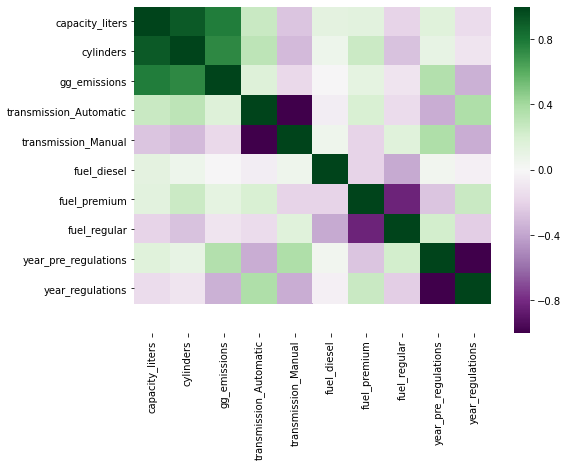

In [13]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(all_cars_eda.corr(), cmap="PRGn")
ax.set_ylim(11.0, 0)

plt.savefig('images/heatmap_correlation_gge.jpg', bbox_inches="tight")
plt.savefig('images/heatmap_correlation_gge.svg', bbox_inches="tight");

And now a Greenhouse Gas Emissions correlation matrix to identify features' relationship with gge and with each other.>>

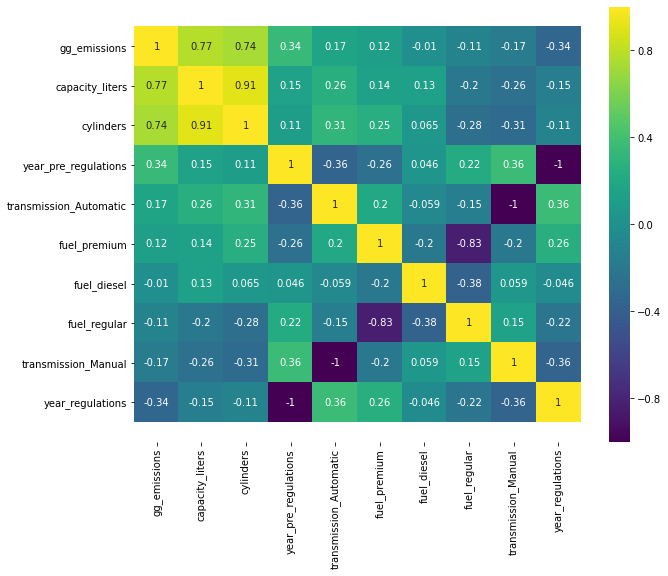

In [14]:
k = 11
cols = all_cars_eda.corr().nlargest(k, 'gg_emissions')['gg_emissions'].index
cm = all_cars_eda[cols].corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm, annot=True, cmap = 'viridis')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig('images/correlation_matrix_gge.jpg', bbox_inches="tight")
plt.savefig('images/correlation_matrix_gge.svg', bbox_inches="tight");

### TAKEAWAYS of Correlation Matrix:
- Cylinders highly correlated to capacity liters.  Capacity liters more highly correlated to gge, so will likely keep capacity liters and remove cylinders from the model
- Transmission & years are fairly high as well in correlation to each other, so will need to play with those in the model to see if condition number can be improved

- 

Create a pair plot for a deeper look at relationship between all features and variable >>

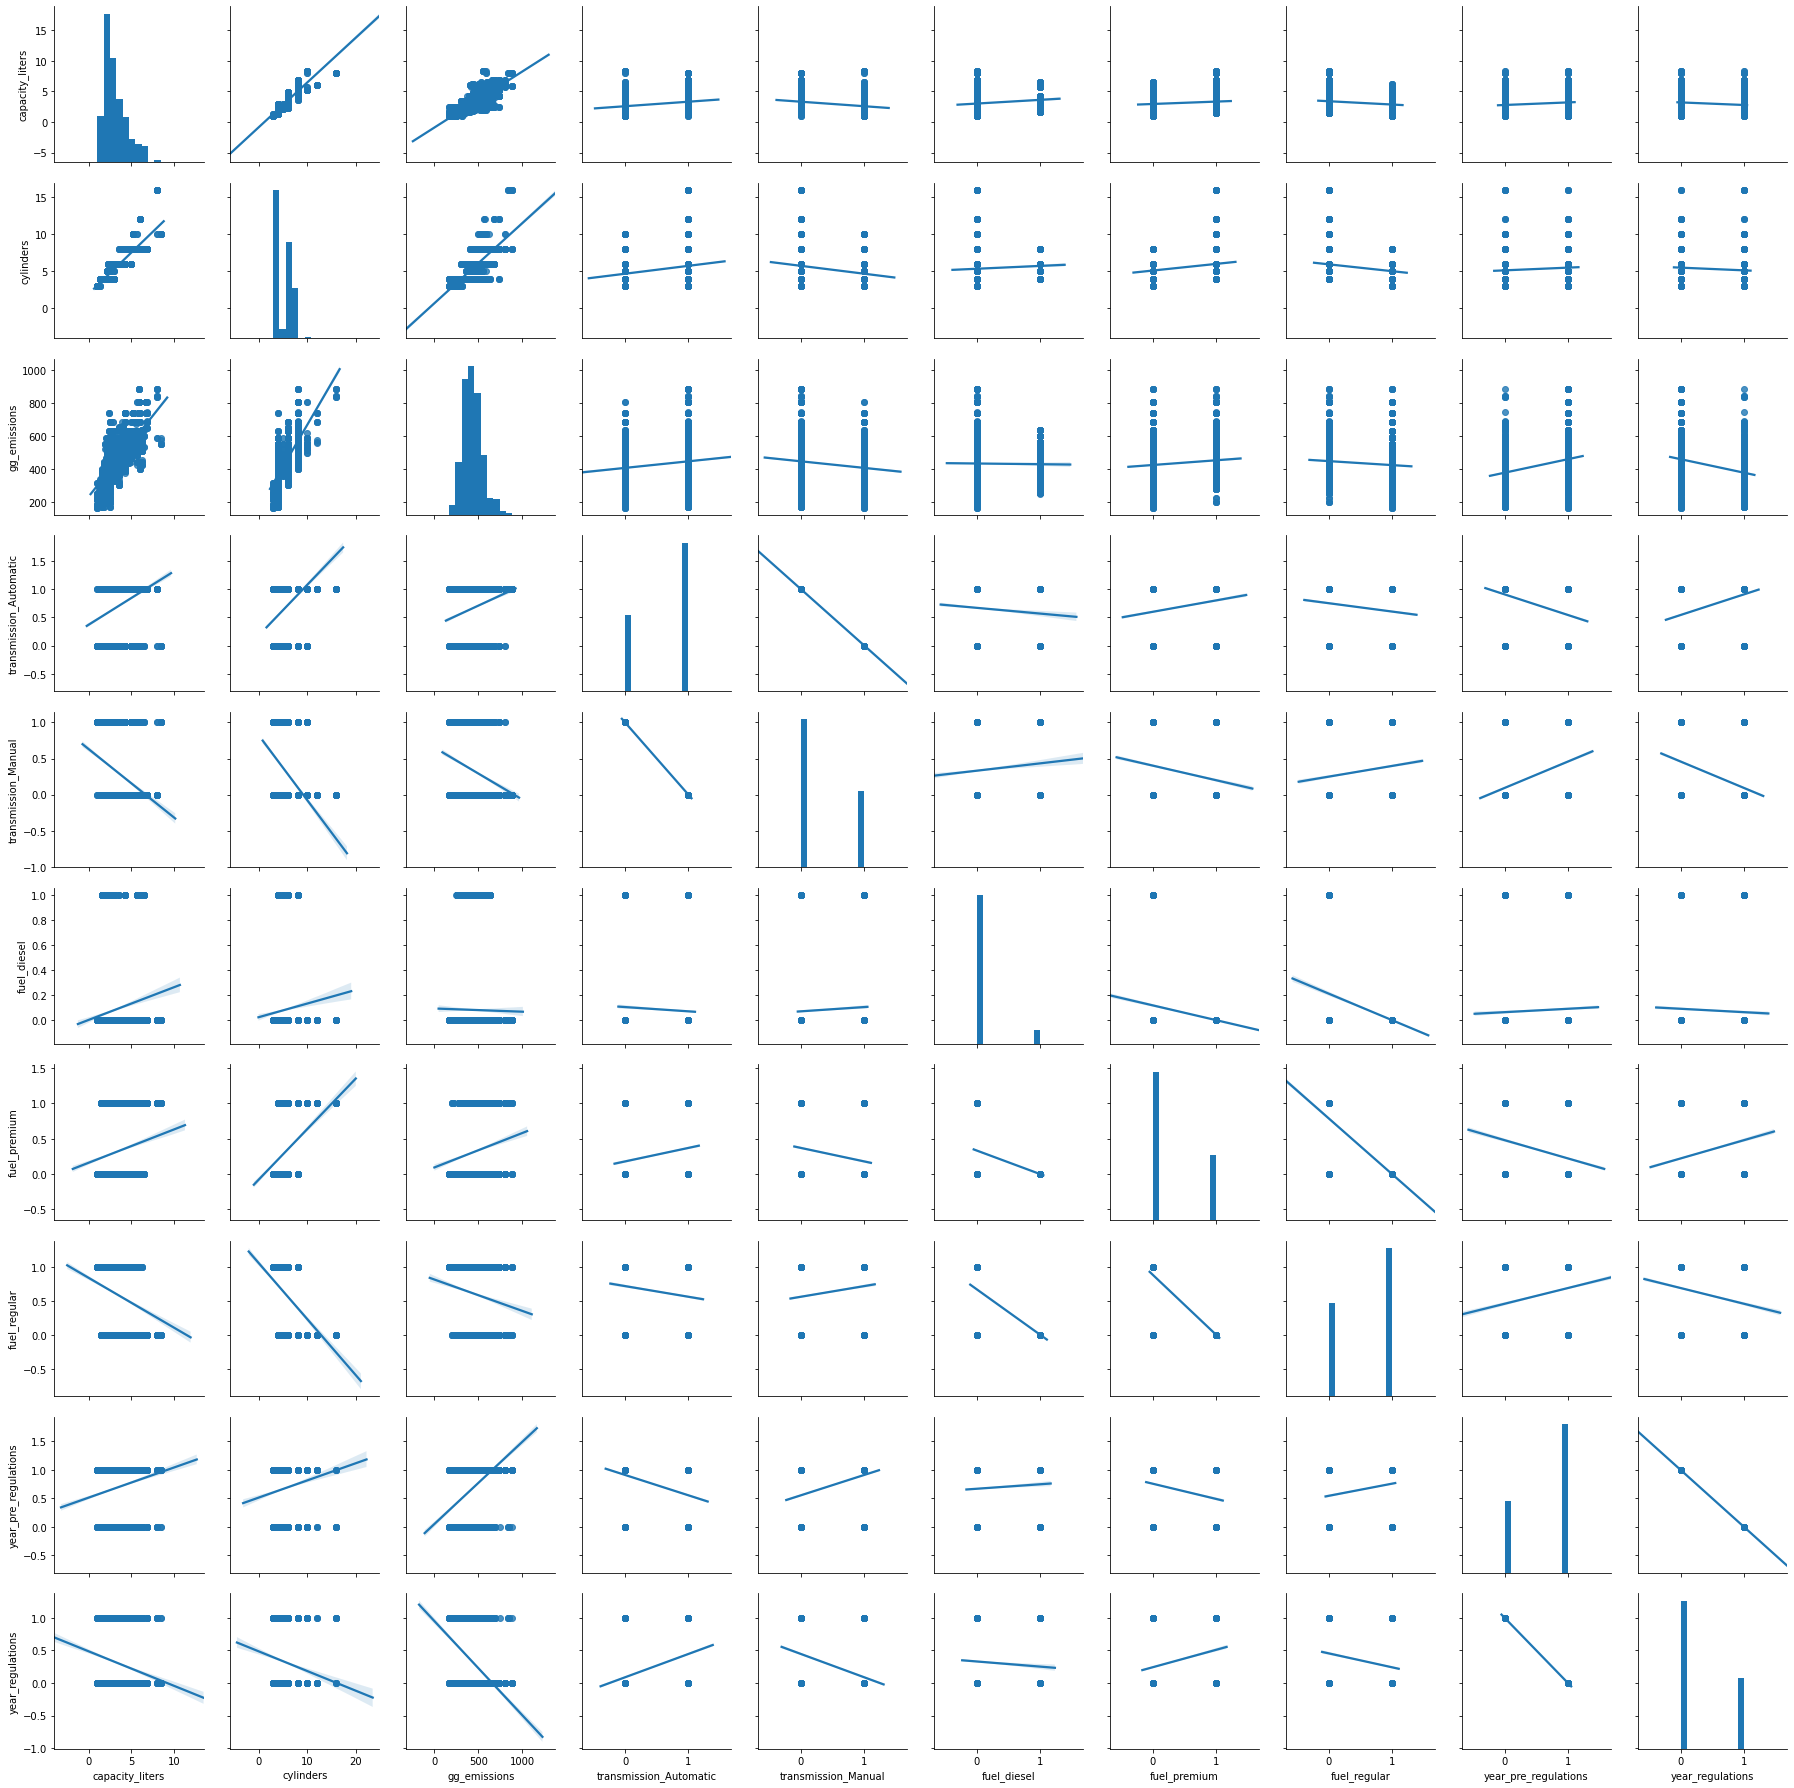

In [15]:
sns.pairplot(all_cars_eda, kind='reg')

plt.savefig('images/pairplot_gge.jpg', bbox_inches="tight");

-

### STEP 3: BUILD THE MODEL

#### STEP 3.1: CREATE TEST_TRAIN_SPLIT 80/20

In [16]:
X = all_cars_eda.drop('gg_emissions',axis=1) #create 'X' features for model
y = all_cars_eda['gg_emissions']  # identify y value for model = greenhouse gas emissions

In [17]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

#### STEP 3.2: STANDARDIZE WITH STANDARDIZE SCALER & CREATE OLS

In [18]:
X_train_val.columns

Index(['capacity_liters', 'cylinders', 'transmission_Automatic',
       'transmission_Manual', 'fuel_diesel', 'fuel_premium', 'fuel_regular',
       'year_pre_regulations', 'year_regulations'],
      dtype='object')

In [19]:
scaler = StandardScaler()

gge_model_v1 = sm.OLS(y_train_val, sm.add_constant(scaler.fit_transform(X_train_val)))


gge_model_v1_results = gge_model_v1.fit()

#summarize the model
gge_model_v1_results.summary(xname=['Intercept', 'capacity_liters', 'cylinders', 
                                    'transmission_Automatic','transmission_Manual', 
                                    'fuel_diesel', 'fuel_premium', 'fuel_regular',
                                    'year_pre_regulations', 'year_regulations'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gg_emissions   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     1432.
Date:                Wed, 15 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:34:00   Log-Likelihood:                -23427.
No. Observations:                4208   AIC:                         4.687e+04
Df Residuals:                    4201   BIC:                         4.691e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                433.5613      0.977    443.773      0.000     431.646     435.477
capacity_liters           61.5241      2.424     25.380      0.000      56.772      66.277
cylinders                 20.2470      2.494      8.118      0.000      15.357      25.137
transmission_Automatic     2.6915      0.568      4.740      0.000       1.578       3.805
transmission_Manual       -2.6915      0.568     -4.740      0.000      -3.805      -1.578
fuel_diesel              -10.3408      0.855    -12.089      0.000     -12.018      -8.664
fuel_premium               5.4912      0.656      8.366      0.000       4.204       6.778
fuel_regular               0.6608      0.581      1.137      0.255      -0.478       1.800
year_pre_regulations      15.1952      0.565     26.893      0.000      14.087      16.303
year_regulations         -15.1952      0.565    -26.893      0.000     -16.303     -14.087
==============================================================================
Omnibus:                      306.418   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              711.834
Skew:                           0.451   Prob(JB):                    2.67e-155
Kurtosis:                       4.802   Cond. No.                     1.45e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.4e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### TAKEAWAYS FROM OLS:
- R^2 fairly good
- Condition Number way too high -- will need to take corrective action.
- Regular fuel (x7) has a high p value.  Will monitor but as remove other features could resolve.

- 

### STEP 3.3: ADDRESS HIGH CONDITION NUMBER

Tested various options for feature combinations. 

Started with removing `cylinders` since had already identified through correlation matrix that this was collinear with engine capacity (`capacity_liters`)

Also removed dummies columns that were redundant if they only had one pair (e.g. with `year_pre_regulations` and `year_regulations` only need one to be in model).

In end, removed:
- `cylinders`
- `transmission_Manuel`
- `fuel_diesel`
- `year_pre_regulations`

In [21]:
X_train_val = X_train_val.drop(['cylinders','transmission_Manual','fuel_diesel','year_pre_regulations'],axis=1)

In [29]:
gge_model_v2 = sm.OLS(y_train_val, sm.add_constant(scaler.fit_transform(X_train_val)))

gge_model_v2_results = gge_model_v2.fit()

gge_model_v2_results.summary(xname=['Intercept', 'capacity_liters', 
                                    'transmission_Automatic', 'fuel_premium',
                                    'fuel_regular', 'year_regulations'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gg_emissions   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     1680.
Date:                Wed, 15 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:47:57   Log-Likelihood:                -23460.
No. Observations:                4208   AIC:                         4.693e+04
Df Residuals:                    4202   BIC:                         4.697e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                433.5613      0.985    440.385      0.000     431.631     435.491
capacity_liters           79.1392      1.089     72.683      0.000      77.005      81.274
transmission_Automatic     6.7884      1.131      6.003      0.000       4.571       9.006
fuel_premium              25.8182      1.805     14.302      0.000      22.279      29.357
fuel_regular              19.4822      1.804     10.797      0.000      15.945      23.020
year_regulations         -31.0253      1.136    -27.310      0.000     -33.253     -28.798
==============================================================================
Omnibus:                      337.500   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              857.741
Skew:                           0.467   Prob(JB):                    5.54e-187
Kurtosis:                       5.005   Cond. No.                         3.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### TAKEAWAYS FROM LATEST MODEL:
- Got Condition number to drop significantly
- P values all look good
- R^2 remained relatively high

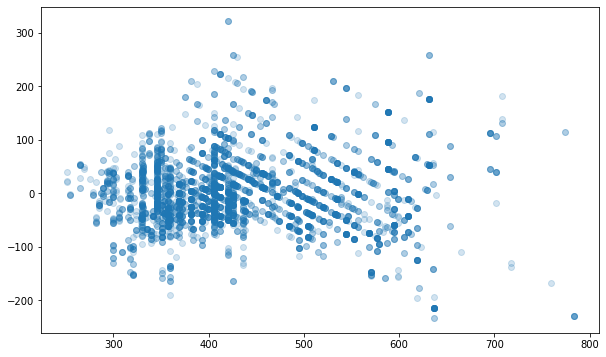

In [30]:
plt.figure(figsize=(10,6))
plt.scatter(gge_model_v2_results.predict(), gge_model_v2_results.resid, alpha=0.2)

plt.savefig('images/model2_residuals.jpg', bbox_inches="tight")
plt.savefig('images/model2_residuals.svg', bbox_inches="tight");

Residuals above of model look okay.  Feeling good about this model based on all results seen above.

Will now move to next phase of modeling for validation/cross-validation.

- 

### STEP 3.4: VALIDATION

First update the test model to reflect chosen features for model >>

In [31]:
X_test = X_test.drop(['cylinders','transmission_Manual','fuel_diesel','year_pre_regulations'],axis=1)

In [32]:
X = X.drop(['cylinders','transmission_Manual','fuel_diesel','year_pre_regulations'],axis=1)

Then create validation buckets for x and y >>

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

For testing, look at a polynomial model to see what affect it might have >>

In [34]:
lm = LinearRegression()

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_val_poly = poly.fit_transform(X_train_val.values)
X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [35]:
lm.fit(X_train_val, y_train_val)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_poly.fit(X_train_val_poly, y_train_val)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.665
Degree 2 polynomial regression val R^2: 0.690


-

Now test the model regular and polynomial values >>

In [36]:
lm.fit(X_train_val, y_train_val)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

lm_poly.fit(X_train_val_poly, y_train_val)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.691
Linear Regression test R^2: 0.691


Everything looks good on validation and test.  

Polynomial might be an option, but R^2 values aren't that different.  Did explore doing polynomial model (see 'Appendix' section at bottom of this worksheet), but conditional number went up and had odd take on coefficients and features -- prefer to stick to simplier model and keep then value of easier to report to people and ability to take action on the findings.

To be certain, since using smaller sample set, will also run cross-validation with k-fold CV >>

In [37]:
# for original model

cross_val_score(lm, X_train_val, y_train_val, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.6400905 , 0.67794834, 0.66720501, 0.65285322, 0.68670301])

In [38]:
# for polynomial model

cross_val_score(lm_poly, X_train_val_poly, y_train_val, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.67003904, 0.68549475, 0.70041688, 0.68295133, 0.70326947])

Looks good - R^2 values relatively similiar.  Now let's try Lasso & Ridge for potential to refine model.

-

### STEP 3.5: LASSO & RIDGE REGULARIZATION

### RIDGE MODEL

Find alpha for ridge model, starting with simple function for developing mae >>

In [39]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [40]:
alphalist_ridge = 10**(np.linspace(-2,2,200))
err_vec_val_ridge = np.zeros(len(alphalist_ridge)) 
err_vec_train_ridge = np.zeros(len(alphalist_ridge))

for i,curr_alpha in enumerate(alphalist_ridge):

    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train_val, y_train_val)
    
    val_set_pred_ridge = pipe.predict(X_val)
    err_vec_val_ridge[i] = mae(y_val, val_set_pred_ridge)

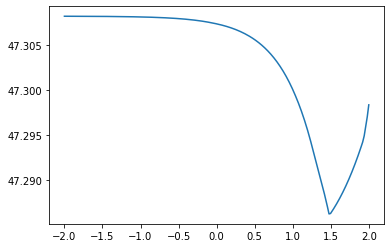

In [41]:
plt.plot(np.log10(alphalist_ridge), err_vec_val_ridge);

In [42]:
np.min(err_vec_val_ridge)

47.28623323970089

In [43]:
alpha_ridge = alphalist_ridge[np.argmin(err_vec_val_ridge)]

Now that have alpha/lambda, can develop Ridge model & find our coefficients >>

In [121]:
lr_model_ridge = Ridge(alpha = alpha_ridge)
lr_model_ridge.fit(X_train_val, y_train_val)

print('COEFFICIENTS for RIDGE Model:')
list(zip(X_train_val.columns, lr_model_ridge.coef_))

COEFFICIENTS for RIDGE Model:


[('capacity_liters', 60.19222009830541),
 ('transmission_Automatic', 13.464090054103353),
 ('fuel_premium', 47.49635509672385),
 ('fuel_regular', 32.65820777307923),
 ('year_regulations', -63.29001086355502)]

In [45]:
test_set_pred_ridge = lr_model_ridge.predict(X_test)

#### TESTING & DIAGNOSITICS - FOR RIDGE

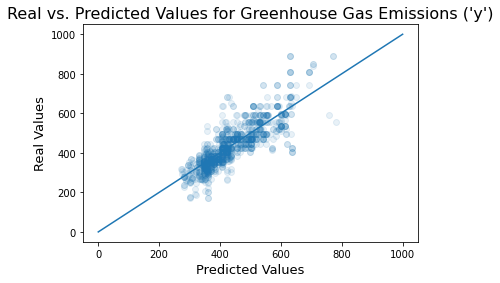

In [125]:
plt.title("Real vs. Predicted Values for Greenhouse Gas Emissions ('y')", size=16)
plt.scatter(test_set_pred_ridge, y_test, alpha=.1)
plt.xlabel('Predicted Values', size = 13)
plt.ylabel('Real Values', size = 13)
plt.plot(np.linspace(0,1000,10), np.linspace(0,1000,10))
plt.savefig('images/ridge_real_to_predict.jpg', bbox_inches="tight")
plt.savefig('images/ridge_real_to_predict.svg', bbox_inches="tight");

In [116]:
r2_score_ridge = r2_score(y_test, test_set_pred_ridge)

mae_ridge = mean_absolute_error(y_test, test_set_pred_ridge)

print('RIDGE MODEL:')
print(f'R^2: {r2_score_ridge}')
print(f'Mean Absolute Error: {mae_ridge}')

RIDGE MODEL:
R^2: 0.6903722423162104
Mean Absolute Error: 47.19790875474612


-

### LASSO MODEL

Find alpha for lasoo model, starting with finding developing mae >>

In [49]:
alphalist_lasso = 10**(np.linspace(-2,2,200))
err_vec_val_lasso = np.zeros(len(alphalist_lasso)) 
# err_vec_train_lasso = np.zeros(len(alphalist_lasso))

for i,curr_alpha in enumerate(alphalist_lasso):

    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train_val, y_train_val)
    
    val_set_pred_lasso = pipe.predict(X_val)
    err_vec_val_lasso[i] = mae(y_val, val_set_pred_lasso)

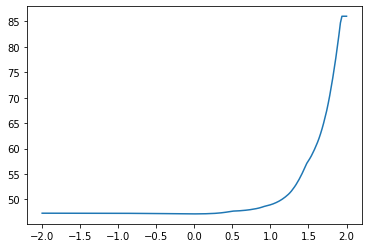

In [50]:
plt.plot(np.log10(alphalist_lasso), err_vec_val_lasso);

In [51]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val_lasso)

47.16626258167027

In [100]:
## This is the value of alpha that gave us the lowest error
alpha_lasso = alphalist_lasso[np.argmin(err_vec_val_lasso)]

Now that have alpha/lambda, can develop Lasso model & find our coefficients >>

In [126]:
model_lasso = Lasso(alpha = alpha_lasso)

model_lasso.fit(X_train_val, y_train_val)

print('COEFFICIENTS for LASSO Model:')
dict(zip(X_train_val.columns, model_lasso.coef_))

COEFFICIENTS for LASSO Model:


{'capacity_liters': 60.23716584200582,
 'transmission_Automatic': 9.552830288197704,
 'fuel_premium': 33.16088112384506,
 'fuel_regular': 19.203145188683628,
 'year_regulations': -59.56451385881141}

#### TESTING & DIAGNOSITICS - FOR LASSO MODEL

In [54]:
test_set_pred_lasso = lr_model_lasso.predict(X_test)

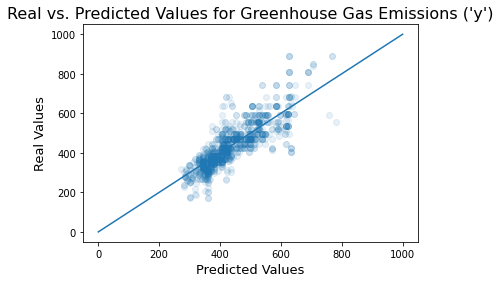

In [70]:
plt.title("Real vs. Predicted Values for Greenhouse Gas Emissions ('y')", size=16)
plt.scatter(test_set_pred_lasso, y_test, alpha=.1)
plt.xlabel('Predicted Values', size = 13)
plt.ylabel('Real Values', size = 13)
plt.plot(np.linspace(0,1000,10), np.linspace(0,1000,10))
plt.savefig('images/lasso_real_to_predict.jpg', bbox_inches="tight")
plt.savefig('images/lasso_real_to_predict.svg', bbox_inches="tight");

Calculate key metrics of this model >>

In [115]:
r2_score_lasso = r2_score(y_test, test_set_pred_lasso)

mae_lasso = mean_absolute_error(y_test,test_set_pred_lasso)

print('LASSO MODEL:')
print(f'R^2: {r2_score_lasso}')
print(f'Mean Absolute Error: {mae_lasso}')

LASSO MODEL:
R^2: 0.6875868818662549
Mean Absolute Error: 47.43280666154661


### STEP 3.5: CONCLUSION & SELECTION OF MODEL

With Ridge results having a higher R^2 than Lasso results and otherwise similar results, will choose RIDGE MODEL as selected model for this project.

-

### EXTRA: CREATE A LARS PATH

In [58]:
from sklearn.linear_model import lars_path

In [59]:
## Scale the variables
std = StandardScaler()
std.fit(X_train_val.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [60]:
X_tr = std.transform(X_train_val.values)

In [61]:
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train_val.values, method='lasso')

Computing regularization path using the LARS ...


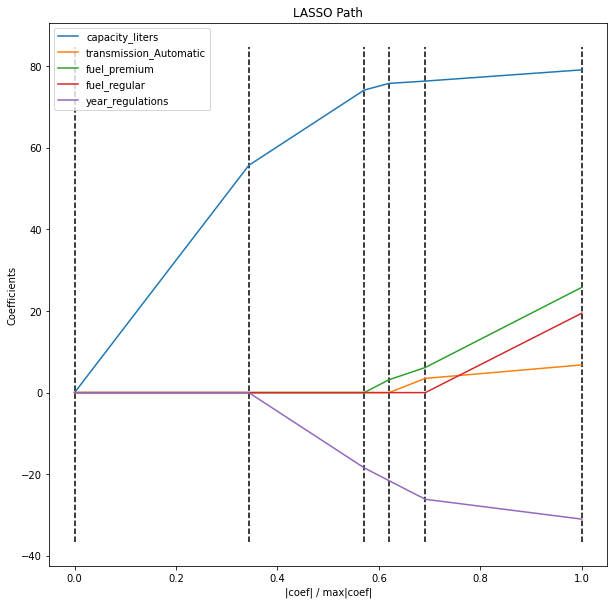

In [62]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)

plt.savefig('images/LASSO_path.jpg', bbox_inches="tight");